# Time series analysis of Google Trends for "Fourier Transform"

In [ ]:
%pip install pytrends

In [1]:
from pytrends.request import TrendReq
import pandas as pd

## Get Google trends data

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)

In [3]:
keywords = ['Fourier Transform']
pytrends.build_payload(keywords, cat=0, timeframe='all', geo='', gprop='')


In [4]:
trends_df=pytrends.interest_over_time()


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Note the [maintainer stepped down](https://github.com/GeneralMills/pytrends/issues/636) and the repo is archived. They raise serious concerns about data quality but suggest trendspy as an alternative.

<Axes: xlabel='date'>

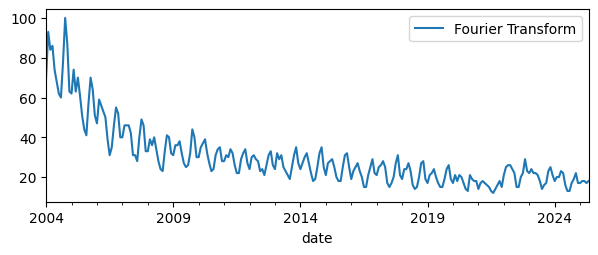

In [5]:
trends_df[~trends_df.isPartial].plot(figsize=[7,2.5])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

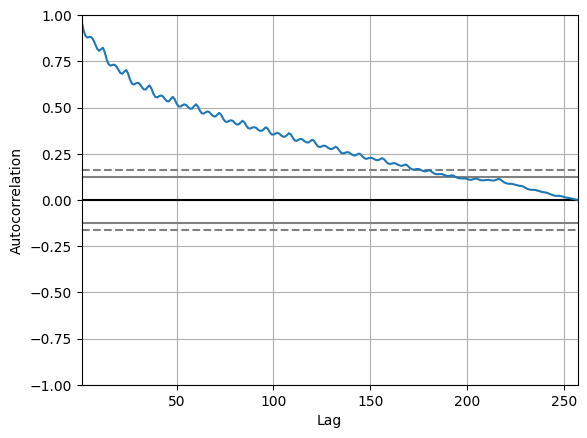

In [6]:
pd.plotting.autocorrelation_plot(trends_df[~trends_df.isPartial].dropna())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

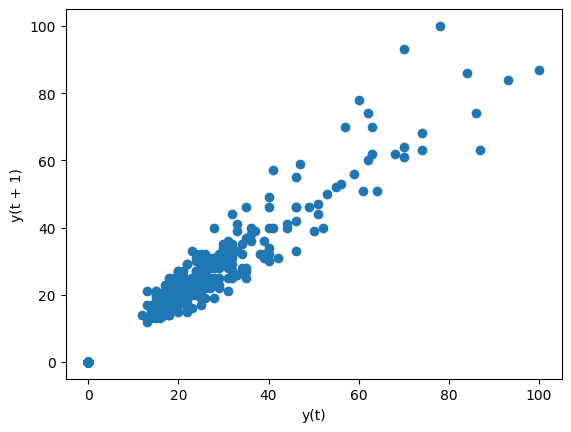

In [7]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].dropna(),lag=1)

In [8]:
(trends_df[~trends_df.isPartial].dropna()
 [['Fourier Transform']]
 .assign(Fourier_Transform_shifted_1m=trends_df
         [~trends_df.isPartial]
         .dropna()
         [['Fourier Transform']]
         .shift(periods=1)
        )
 .corr()
)

,Fourier Transform,Fourier_Transform_shifted_1m
Fourier Transform,1.000000,0.930046
Fourier_Transform_shifted_1m,0.930046,1.000000


Periodicity barely stands out in autocorrelation plot against decaying trend. A lag of 1 is the classic use of the lag plot as a test for randomness, as described in the NIST Engineering statistics handbook. In this case the data is definitely not random.

## Diff to remove slow decay, keep periodicity

In [24]:
def non_partial_diff(df):
    return df[~df.isPartial].diff().rename(columns={"Fourier Transform":"Fourier Transform diff"}).dropna()

<Axes: xlabel='date'>

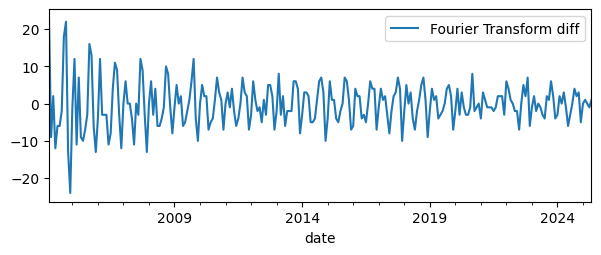

In [25]:
trends_df.pipe(non_partial_diff).plot(figsize=[7,2.5])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

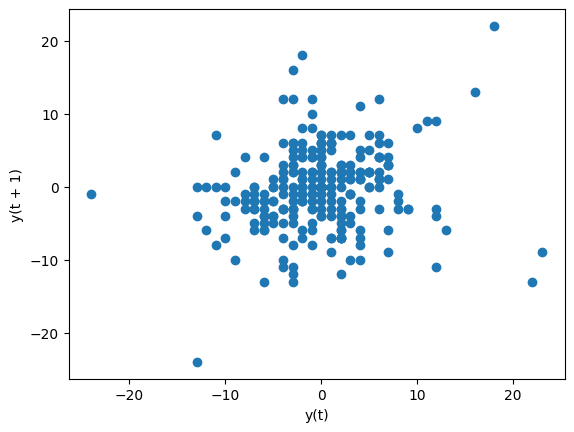

In [26]:
pd.plotting.lag_plot(trends_df.pipe(non_partial_diff),lag=1)

In [27]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform__diff_shift_1m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=1)
        )
 .corr()
)

,Fourier Transform diff,Fourier_Transform__diff_shift_1m
Fourier Transform diff,1.000000,0.169788
Fourier_Transform__diff_shift_1m,0.169788,1.000000


This time the lag 1 plot does show randomness.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

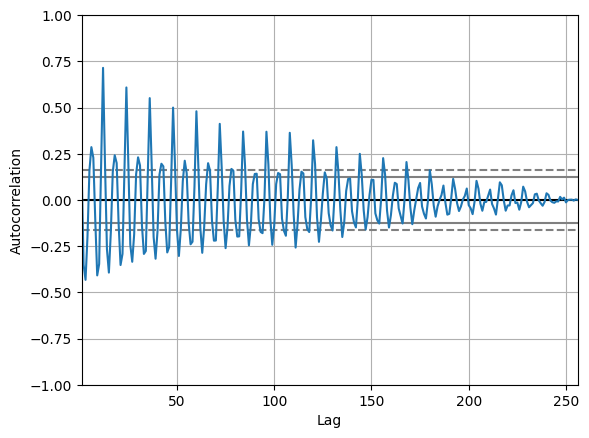

In [28]:
pd.plotting.autocorrelation_plot(trends_df.pipe(non_partial_diff))

Monthly data. High peaks: 12, 24, 36, 48... Smaller peaks half way through. 

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

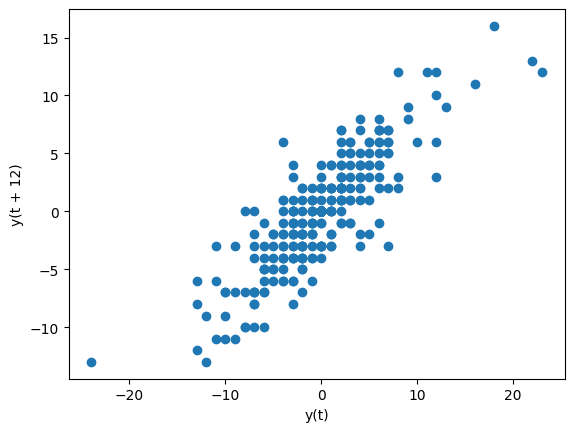

In [29]:
pd.plotting.lag_plot(trends_df.pipe(non_partial_diff),lag=12)

In [31]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform_diff_shift_12m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=12)
        )
 .corr()
)

,Fourier Transform diff,Fourier_Transform_diff_shift_12m
Fourier Transform diff,1.000000,0.845154
Fourier_Transform_diff_shift_12m,0.845154,1.000000


The lag plots for 12 and 6 months lag further confirm the relationship.

<Axes: xlabel='y(t)', ylabel='y(t + 6)'>

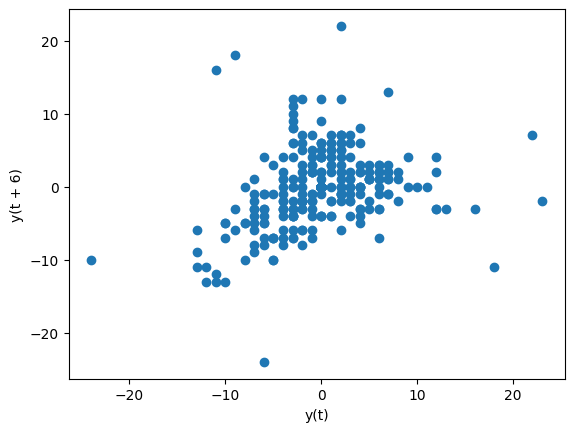

In [17]:
pd.plotting.lag_plot(trends_df[~trends_df.isPartial].diff().dropna(),lag=6)

In [32]:
(trends_df
 .pipe(non_partial_diff)
 [['Fourier Transform diff']]
 .assign(Fourier_Transform_diff_shift_6m=trends_df
         .pipe(non_partial_diff)
         [['Fourier Transform diff']]
         .shift(periods=6)
        )
 .corr()
)

,Fourier Transform diff,Fourier_Transform_diff_shift_6m
Fourier Transform diff,1.000000,0.300553
Fourier_Transform_diff_shift_6m,0.300553,1.000000


Inspired from a Linked In post by Kunpeng (KP) Liao. Released under the GPL 3.0 Licence.  
https://github.com/stelios-c/sig_proc/blob/main/timeseries.ipynb